<a href="https://colab.research.google.com/github/ysurs/nn_with_karpathy/blob/main/wavenet_part6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## makemore: part 5 (building a WaveNet)

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('/content/drive/MyDrive/building_makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class Embedding:

  def __init__(self,num_embeddings,embedding_dim):
    self.weight=torch.randn((num_embeddings,embedding_dim))
  
  def __call__(self,IX):
    self.out=self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


# -----------------------------------------------------------------------------------------------

class Flatten:

  def __call__(self,x):
    self.out=x.view(x.shape[0],-1)
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class FlattenConsecutive:

  def __init__(self,n):
    self.n=n   ## how many consecutive elements you want

  def __call__(self,x):
    #self.out=x.view(x.shape[0],-1)
    B,T,C=x.shape
    x=x.view(B,T//self.n,C*self.n)
    
    if x.shape[1]==1:
      x=x.squeeze(1)
    self.out=x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
  
class Sequential:

  def __init__(self,layers):
    self.layers=layers
  
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out=x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]




In [9]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP


model = Sequential([
  Embedding(vocab_size,n_embd),
  FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
  

76579


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,),)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits=model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  # break

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476


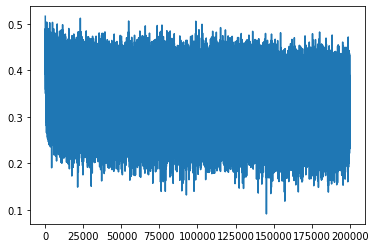

In [ ]:
plt.plot(lossi)

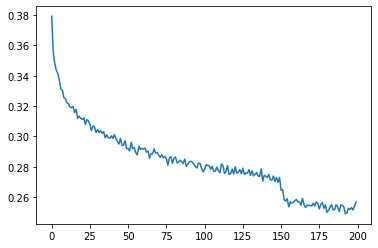

In [12]:
# Improving the above plot using mean and view methods
#This view of loss creates rows of 1000 elements each

plt.plot((torch.tensor(lossi).view(-1,1000)).mean(1))

In [13]:
for layer in model.layers:
  layer.training=False

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits=model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936527013778687


In [15]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits=model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


Performance log:



* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.918, val 2.027

* final (76k params) train: 1.76 val: 1.99 (best)

### Rough space:

In [ ]:
Xtr.shape,Ytr.shape

(torch.Size([182778, 8]), torch.Size([182778]))

In [ ]:
indices=torch.randint(0,Xtr.shape[0],(4,))

In [ ]:
Xb,Yb=Xtr[indices],Ytr[indices]

In [ ]:
logits=model(Xb)

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
# This is the output from the embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [ ]:
# This is the output from flattening layer

model.layers[1].out.shape

torch.Size([4, 80])

In [ ]:
# This is the output from linear layer
model.layers[2].out.shape

torch.Size([4, 200])

In [ ]:
# current implementation

(torch.randn(4,80)@torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 200])

In [ ]:
# wavenet implementation
(torch.randn(4,4,20)@torch.randn(20,200)+torch.randn(200)).shape

torch.Size([4, 4, 200])

### We want to send 2 characters to the linear layer at a time and we have to group 2 consecutive characters

In [ ]:
e=torch.randn((2,4,4))
xme=e.mean(0,keepdims=True)

In [ ]:
e

tensor([[[-0.8994,  1.3091, -0.8432, -0.3609],
         [-0.3740,  0.3658, -1.3351,  0.5365],
         [-1.3767, -0.5914,  1.8114, -0.0505],
         [-1.2442, -0.0556,  0.2869,  0.5559]],

        [[-0.8601,  0.4954, -0.3190,  0.2049],
         [ 0.1422, -0.0180, -1.2665,  0.8443],
         [-1.3685,  1.1905,  1.2665, -1.1051],
         [-0.3204,  0.6370,  0.1871,  1.6336]]])

In [ ]:
e.mean(0)

tensor([[-0.8798,  0.9022, -0.5811, -0.0780],
        [-0.1159,  0.1739, -1.3008,  0.6904],
        [-1.3726,  0.2996,  1.5389, -0.5778],
        [-0.7823,  0.2907,  0.2370,  1.0947]])

In [ ]:
torch.tensor([-0.8601,-0.8994]).mean()

tensor(-0.8798)

In [ ]:
e.mean(2)

tensor([[-0.3889, -0.3269,  0.6420,  0.5278]])

In [ ]:
torch.tensor([-1.2795, 0.5689,  1.2454, 0.8282]).mean()

tensor(0.3407)

In [ ]:
torch.tensor([ 0.5689, -0.5495,  0.1083, -1.4352]).mean()

tensor(-0.3269)

In [ ]:
e

tensor([[[ 1.2383,  0.1769,  0.9475, -1.5193],
         [-1.2109, -0.9184, -1.0092, -0.8222],
         [-0.8350,  0.8540,  0.2152, -1.1328],
         [ 0.5218, -0.0477, -0.4152, -0.6501]],

        [[ 0.6356, -0.5601, -0.6335, -2.5158],
         [-1.1669,  0.1559,  0.0134, -0.5415],
         [ 0.8459, -0.0045, -0.5794,  0.3101],
         [ 0.4962, -1.2201,  1.1269,  1.1427]]])

In [ ]:
xme

tensor([[[ 0.9369, -0.1916,  0.1570, -2.0176],
         [-1.1889, -0.3813, -0.4979, -0.6819],
         [ 0.0055,  0.4248, -0.1821, -0.4114],
         [ 0.5090, -0.6339,  0.3558,  0.2463]]])

In [ ]:
xme.shape

torch.Size([1, 4, 4])

In [ ]:
import torch

In [ ]:
p=torch.tensor([1.2383,1.2109,0.8350,0.5218,0.6356,1.1669,0.8459,0.4962])

In [ ]:
p.mean()

tensor(0.8688)